In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
from PIL import Image
import cv2
import csv
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import layers, models
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

In [2]:
!pip install kaggle

In [7]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [8]:
!kaggle datasets download -d sadmansakibmahi/plant-disease-expert

100% 6.54G/6.54G [00:44<00:00, 219MB/s]
100% 6.54G/6.54G [00:44<00:00, 156MB/s]


In [9]:
! unzip /content/plant-disease-expert.zip

Streaming output truncated to the last 5000 lines.
  inflating: Image Data base/Image Data base/Tomato healthy/Tomato_healthy3715.jpg  
  inflating: Image Data base/Image Data base/Tomato healthy/Tomato_healthy3716.jpg  
  inflating: Image Data base/Image Data base/Tomato healthy/Tomato_healthy3717.jpg  
  inflating: Image Data base/Image Data base/Tomato healthy/Tomato_healthy3718.jpg  
  inflating: Image Data base/Image Data base/Tomato healthy/Tomato_healthy3719.jpg  
  inflating: Image Data base/Image Data base/Tomato healthy/Tomato_healthy372.jpg  
  inflating: Image Data base/Image Data base/Tomato healthy/Tomato_healthy3720.jpg  
  inflating: Image Data base/Image Data base/Tomato healthy/Tomato_healthy3721.jpg  
  inflating: Image Data base/Image Data base/Tomato healthy/Tomato_healthy3722.jpg  
  inflating: Image Data base/Image Data base/Tomato healthy/Tomato_healthy3723.jpg  
  inflating: Image Data base/Image Data base/Tomato healthy/Tomato_healthy3724.jpg  
  inflating: Im

In [10]:
import os

# Specify the name of the new folder
new_folder_name = 'data'

# Get the current working directory
current_path = os.getcwd()

# Create the full path for the new folder
new_folder_path = os.path.join(current_path, new_folder_name)

# Check if the folder already exists
if not os.path.exists(new_folder_path):
    # Create the new folder
    os.mkdir(new_folder_path)
    print(f"Folder '{new_folder_name}' created at {current_path}")
else:
    print(f"Folder '{new_folder_name}' already exists at {current_path}")

# Move subfolders into the new folder
source_folder = "/content/Image Data base/Image Data base/"
subfolders = ["Apple Apple scab", "Apple Black rot", "Apple Cedar apple rust", "Apple healthy"]

for subfolder in subfolders:
    source_path = os.path.join(source_folder, subfolder)
    destination_path = os.path.join(new_folder_path, subfolder)

    try:
        # Move the subfolder to the new folder
        os.rename(source_path, destination_path)
        print(f"Moved '{subfolder}' to '{new_folder_name}' folder")
    except FileNotFoundError:
        print(f"Subfolder '{subfolder}' not found in the source path")
    except FileExistsError:
        print(f"Subfolder '{subfolder}' already exists in the destination path")

Folder 'data' created at /content
Moved 'Apple Apple scab' to 'data' folder
Moved 'Apple Black rot' to 'data' folder
Moved 'Apple Cedar apple rust' to 'data' folder
Moved 'Apple healthy' to 'data' folder


In [23]:
def get_directories(path):
    return [directory for directory in os.listdir(path) if os.path.isdir(os.path.join(path, directory))]

def get_image(image_path):
    return np.array(Image.open(image_path))

def get_files(path):
    return os.listdir(path)

def plot_images(path):
    directories = get_directories(path)
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
    for i, directory in enumerate(directories):
        files_list = get_files(os.path.join(path, directory))
        image_path = os.path.join(path, directory, files_list[0])
        spider_image = get_image(image_path)
        width, height = spider_image.shape[:2]
        axes[i // 2, i % 2].imshow(spider_image)
        axes[i // 2, i % 2].set_title(f"{directory}\nDimensions: {width}x{height}")
        axes[i // 2, i % 2].axis('off')
    plt.show()

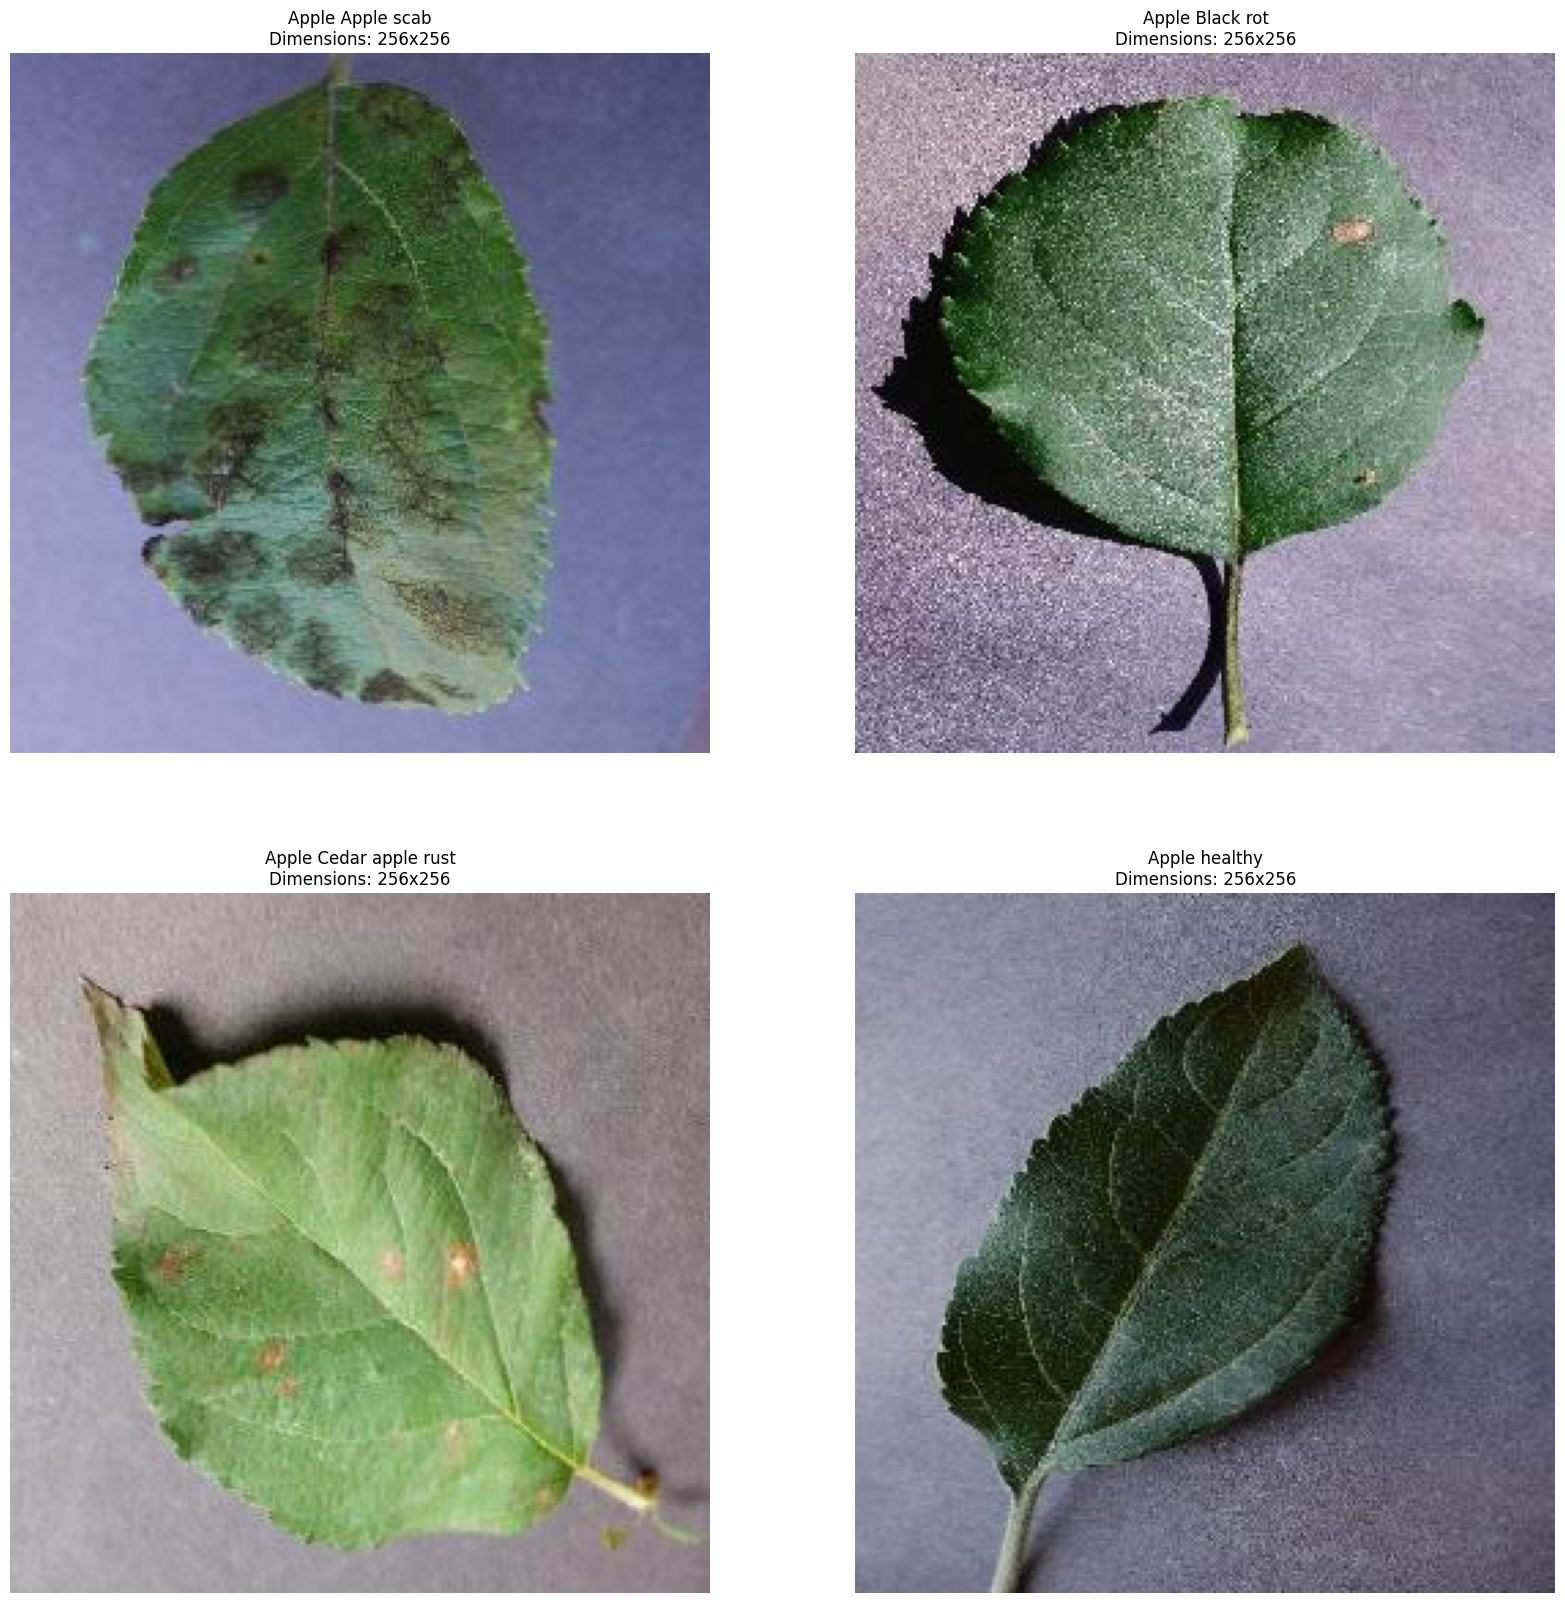

In [24]:
plot_images("/content/data")

In [11]:
# Define the directory containing the image data
sdir = r"/content/data"

# Initialize empty lists for file paths and labels
filepaths = []
labels = []

# Loop through each class in the specified directory
for klass in os.listdir(sdir):
    classpath = os.path.join(sdir, klass)
    flist = os.listdir(classpath)

    for f in flist:
        fpath = os.path.join(classpath, f)
        filepaths.append(fpath)
        labels.append(klass)

df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

In [12]:
Train_df, Test_df= train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=42)
# Train_df, Val_df = train_test_split(Train_df, test_size=0.1, stratify= Train_df['labels'], random_state=42)

In [13]:
model = Sequential()
model.add(ResNet50(weights='imagenet', pooling='avg', include_top=False))
model.add(Dense(4, activation='softmax'))

model.layers[0].trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

94765736/94765736 [==============================] - 0s 0us/step


In [32]:
train_datagen = ImageDataGenerator(
   preprocessing_function=preprocess_input,
   validation_split=0.2
)

# Create data generators for training, validation
train_generator = train_datagen.flow_from_dataframe(
    dataframe= Train_df, x_col='filepaths', y_col='labels',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe= Train_df, x_col='filepaths', y_col='labels',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

model.summary()

Found 11904 validated image filenames belonging to 4 classes.
Found 2976 validated image filenames belonging to 4 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                                 
Total params: 23595908 (90.01 MB)
Trainable params: 8196 (32.02 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [15]:
history = model.fit(
        train_generator,
        #steps_per_epoch=10,
        epochs = 10,
        validation_data= validation_generator,
        #validation_steps=10,
        callbacks=[early_stopping]
)

Epoch 1/10
372/372 [==============================] - 74s 176ms/step - loss: 0.1644 - accuracy: 0.9567 - val_loss: 0.0408 - val_accuracy: 0.9960
Epoch 2/10
372/372 [==============================] - 62s 165ms/step - loss: 0.0282 - accuracy: 0.9974 - val_loss: 0.0198 - val_accuracy: 0.9983
Epoch 3/10
372/372 [==============================] - 62s 166ms/step - loss: 0.0151 - accuracy: 0.9990 - val_loss: 0.0129 - val_accuracy: 0.9990
Epoch 4/10
372/372 [==============================] - 71s 189ms/step - loss: 0.0095 - accuracy: 0.9995 - val_loss: 0.0090 - val_accuracy: 0.9997
Epoch 5/10
372/372 [==============================] - 71s 191ms/step - loss: 0.0066 - accuracy: 0.9995 - val_loss: 0.0074 - val_accuracy: 0.9993
Epoch 6/10
372/372 [==============================] - 63s 169ms/step - loss: 0.0047 - accuracy: 0.9998 - val_loss: 0.0055 - val_accuracy: 0.9993
Epoch 7/10
372/372 [==============================] - 63s 170ms/step - loss: 0.0038 - accuracy: 0.9999 - val_loss: 0.0045 - val_ac

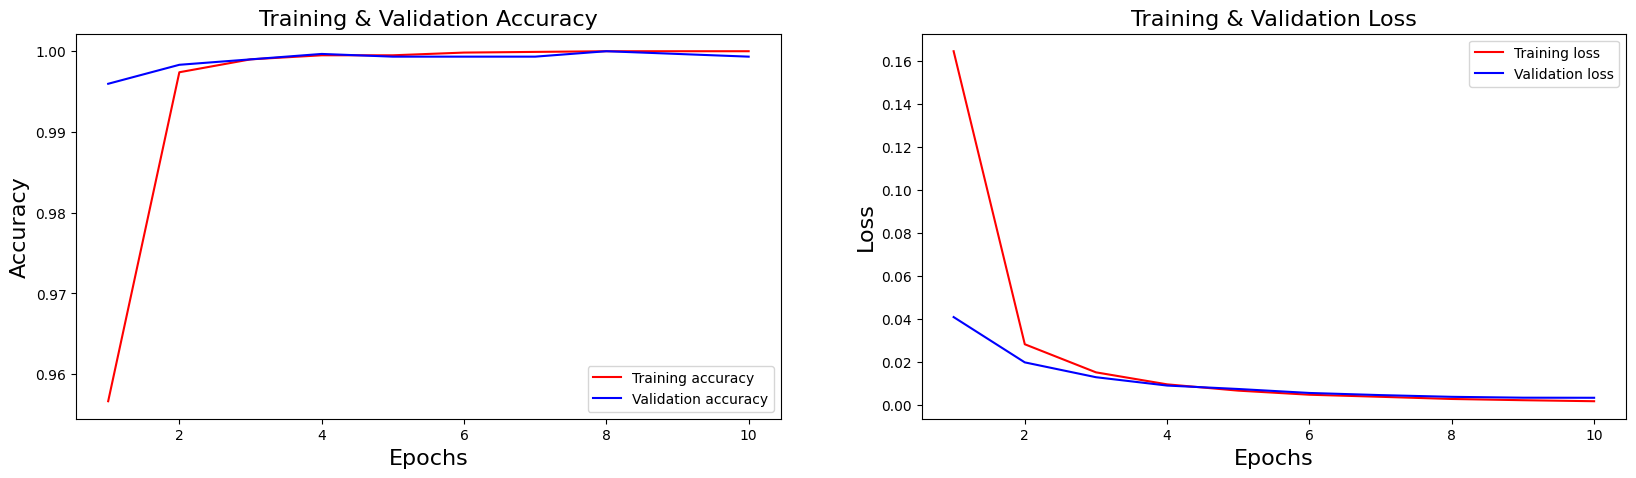

In [22]:
#Plot the training and validation curves
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(20, 5))


# Plot the model accuracy vs Epochs
ax[0].plot(epochs, accuracy, 'r', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()


# Plot the loss vs Epochs
ax[1].plot(epochs, loss_values, 'r', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

In [35]:
test_datagen = ImageDataGenerator(
   preprocessing_function=preprocess_input
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe= Test_df, x_col='filepaths', y_col='labels',
    target_size=(256, 256),
    batch_size=32,
    shuffle=False,
    class_mode='categorical'
)

Found 3720 validated image filenames belonging to 4 classes.


In [18]:
#test accuracy
test_generator.reset()
pred = model.predict(test_generator, steps= len(test_generator), verbose = 1)

predicted_class_indices = np.argmax(pred, axis = 1)
print(predicted_class_indices)

117/117 [==============================] - 19s 155ms/step
[2 2 0 ... 1 1 1]


In [19]:
test_loss, test_acc = model.evaluate(test_generator, verbose= 0)
print(f'Test Accuracy: {test_acc * 100:.2f}%')
print(f'Test Loss: {test_loss * 100:.2f}%')

Test Accuracy: 99.95%
Test Loss: 0.30%


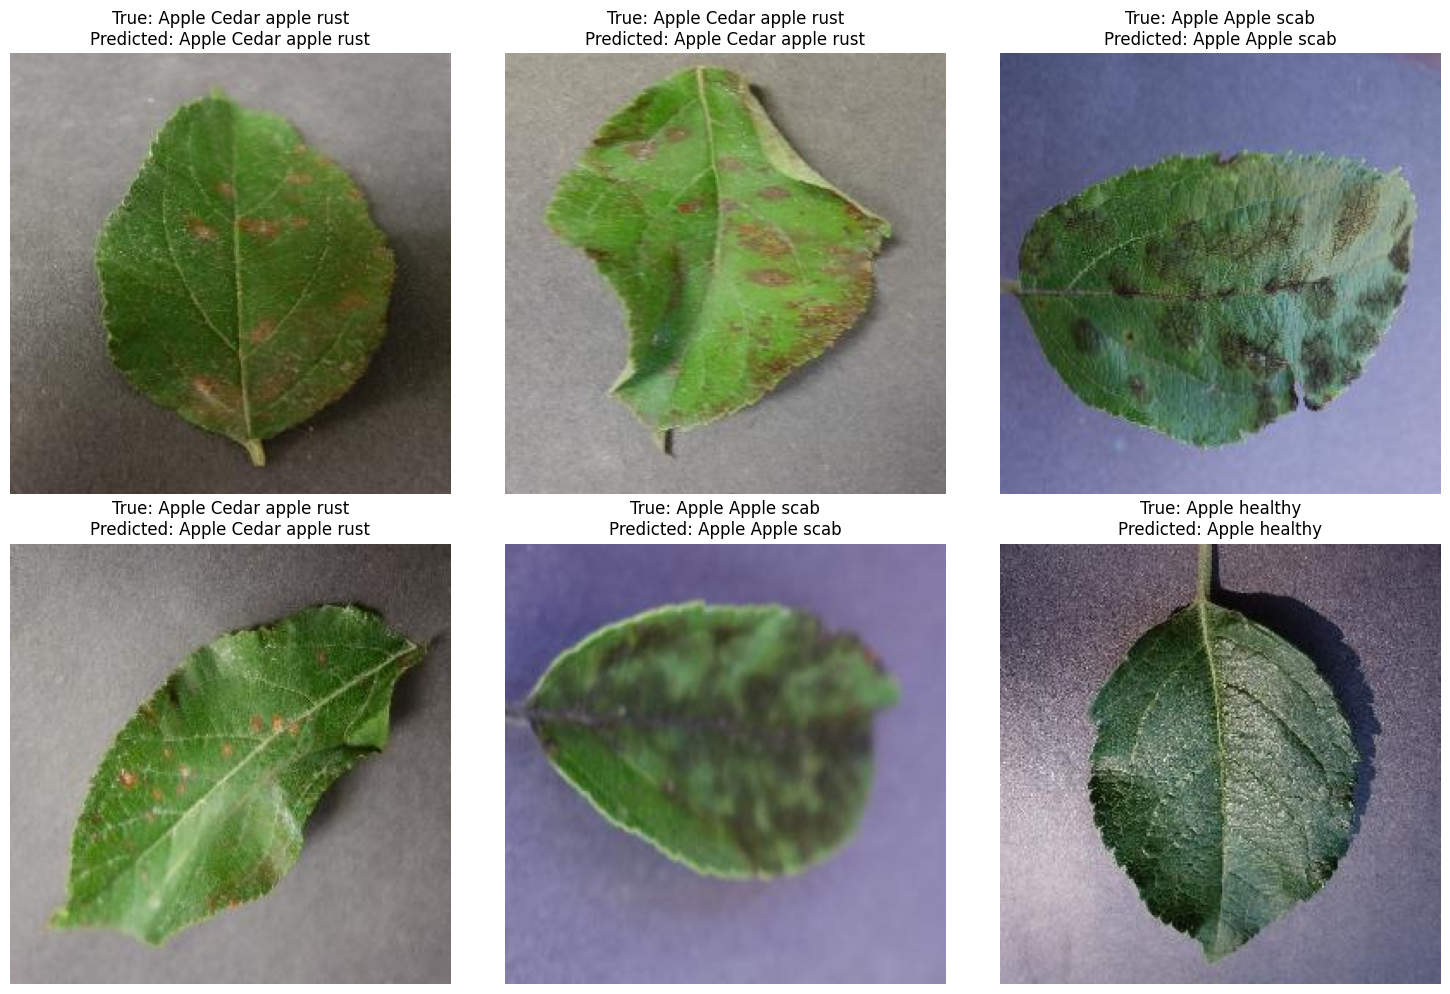

In [46]:
# Assuming you have a list of class labels
class_labels = ["Apple Apple scab", "Apple Black rot", "Apple Cedar apple rust", "Apple healthy"]

# Get the file paths and true labels from the test dataframe
filepaths = Test_df['filepaths'].tolist()
true_labels = Test_df['labels'].tolist()

# Display 6 images along with their predicted and true labels in a subplot
plt.figure(figsize=(15, 10))
for i in range(min(6, len(filepaths))):
    img_path = filepaths[i]
    true_label = true_labels[i]
    predicted_label = class_labels[predicted_class_indices[i]]

    # Load and preprocess the image for display
    img = plt.imread(img_path)

    # Set up the subplot
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(f'True: {true_label}\nPredicted: {predicted_label}')
    plt.axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Confusion Matrix')

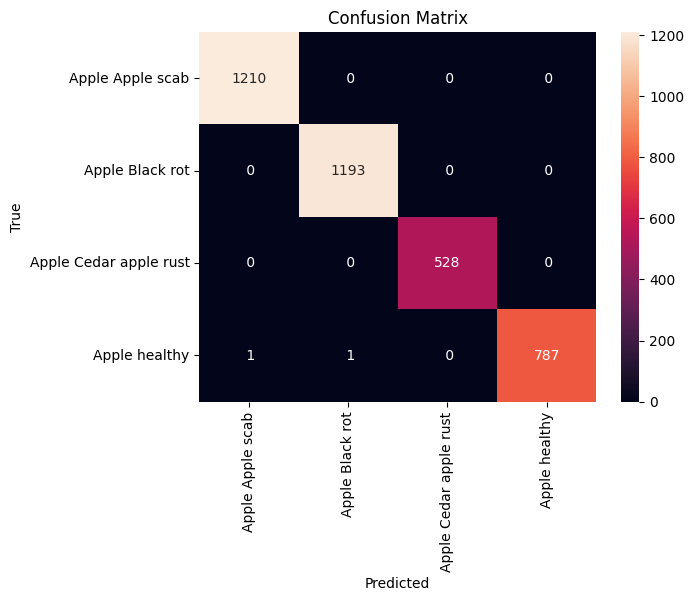

In [43]:
encoder = LabelEncoder()
encoder.fit(Test_df["labels"])
y= encoder.fit_transform(Test_df["labels"])
labels= ["Apple Apple scab", "Apple Black rot", "Apple Cedar apple rust", "Apple healthy"]
sns.heatmap(confusion_matrix(y, predicted_class_indices), xticklabels= labels, yticklabels= labels, annot=True, fmt='2d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')